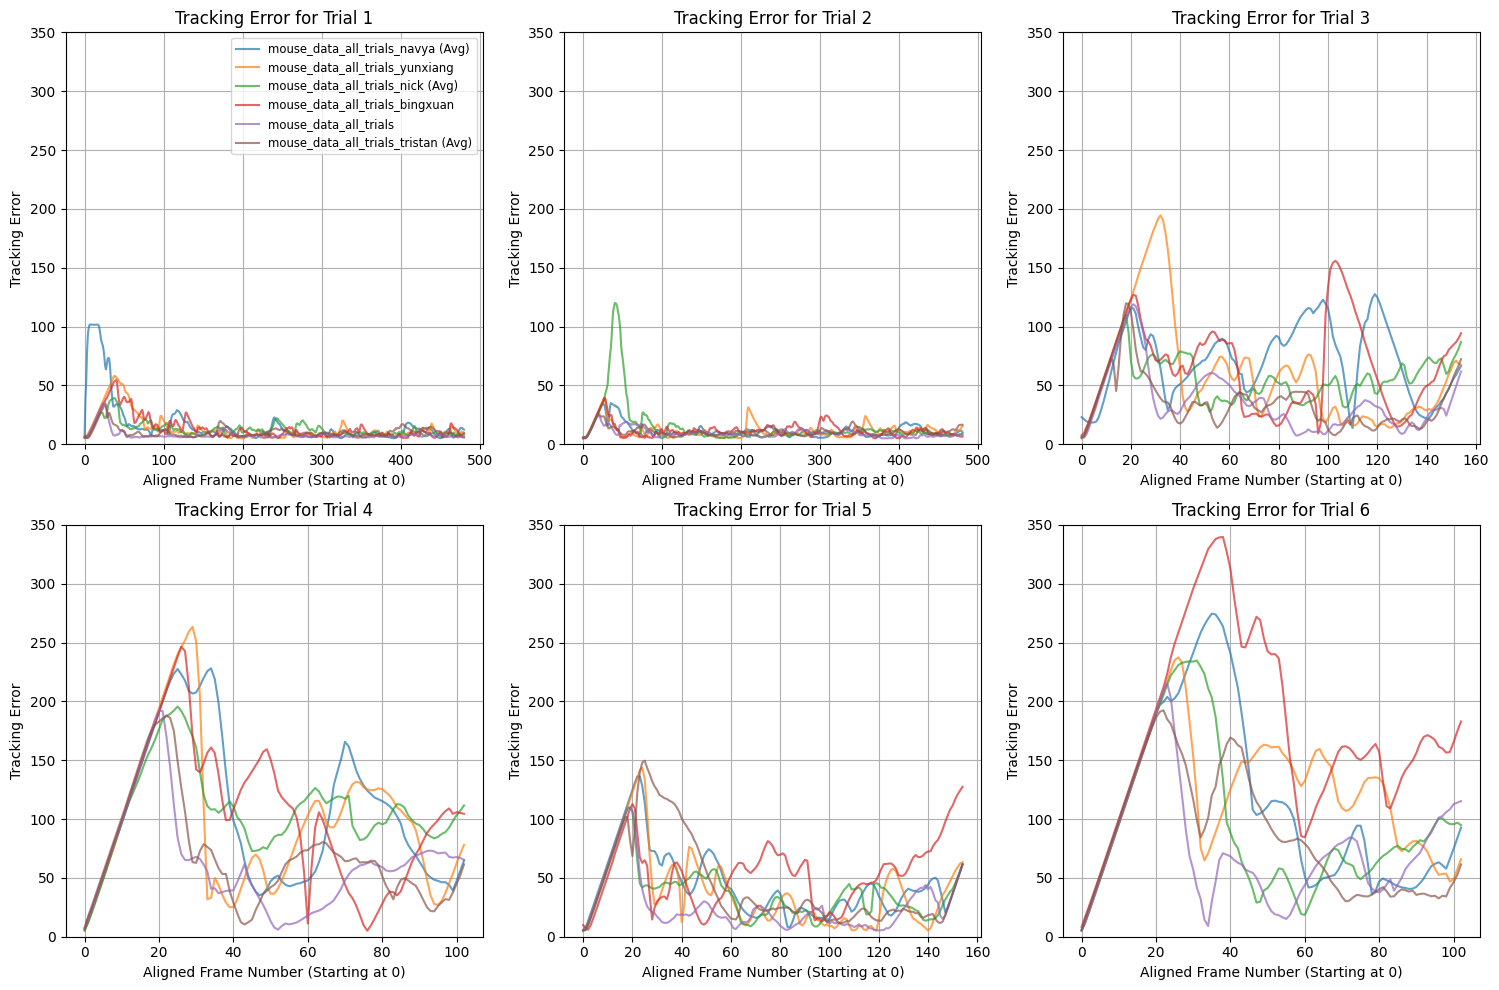

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

folder_path = 'PilotResults'

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

trial_mapping = {6: 4, 7: 5, 8: 0, 9: 1, 10: 2, 11: 3}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for csv_file in csv_files:
    # Read the CSV file
    df = pd.read_csv(csv_file)

    participant_name = os.path.basename(csv_file).replace('.csv', '')

    grouped = df.groupby('TrialNumber')

    participant_trial_data = {}

    for trial_number, group in grouped:
        frame_numbers = group['FrameNumber'].values
        tracking_accuracies = group['TrackingAccuracy'].values
        
        normalized_frame_numbers = frame_numbers - frame_numbers[0]
        
        participant_trial_data[trial_number] = {
            'FrameNumber': normalized_frame_numbers,
            'TrackingAccuracy': tracking_accuracies
        }

    for trial_index in range(6):  
        parts = []

        for original_trial, mapped_trial_data in participant_trial_data.items():
            # Use trialID if it exists
            if 'trialID' in df.columns:
                if original_trial == trial_index:
                    frame_numbers = mapped_trial_data['FrameNumber']
                    tracking_accuracies = mapped_trial_data['TrackingAccuracy']
                    parts.append((frame_numbers, tracking_accuracies))
            else:
                if original_trial == trial_index or original_trial in trial_mapping and trial_mapping[original_trial] == trial_index:
                    frame_numbers = mapped_trial_data['FrameNumber']
                    tracking_accuracies = mapped_trial_data['TrackingAccuracy']
                    parts.append((frame_numbers, tracking_accuracies))

        if len(parts) > 1:
            min_length = min(len(part[0]) for part in parts)  
            combined_frame_numbers = parts[0][0][:min_length] 

            combined_tracking_accuracies = np.mean([part[1][:min_length] for part in parts], axis=0)

            ax = axes[trial_index]
            ax.plot(combined_frame_numbers, combined_tracking_accuracies, label=f'{participant_name} (Avg)', alpha=0.7)
        else:
            for frame_numbers, tracking_accuracies in parts:
                ax = axes[trial_index]
                ax.plot(frame_numbers, tracking_accuracies, label=f'{participant_name}', alpha=0.7)

for trial_index in range(6):
    ax = axes[trial_index]
    ax.set_xlabel('Aligned Frame Number (Starting at 0)')
    ax.set_ylabel('Tracking Error')
    ax.set_title(f'Tracking Error for Trial {trial_index + 1}')
    ax.grid(True)
    ax.set_ylim(0,350)

axes[0].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


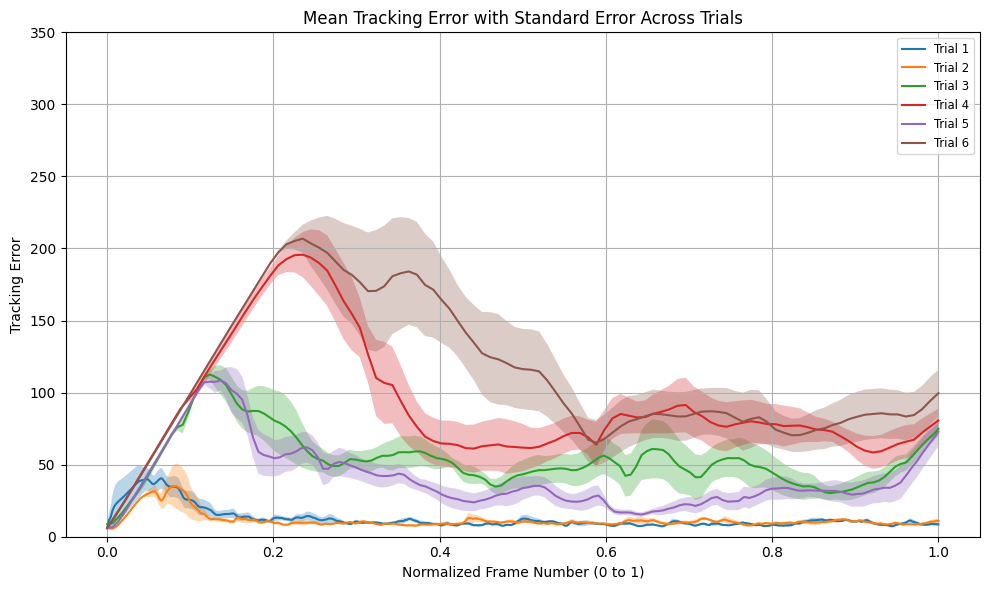

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

folder_path = 'PilotResults'

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

trial_mapping = {6: 4, 7: 5, 8: 0, 9: 1, 10: 2, 11: 3}

all_participants_data = {i: [] for i in range(6)}  # Store tracking accuracies for each trial (6 trials)

for csv_file in csv_files:
    df = pd.read_csv(csv_file)

    participant_name = os.path.basename(csv_file).replace('.csv', '')

    grouped = df.groupby('TrialNumber')

    participant_trial_data = {}

    for trial_number, group in grouped:
        frame_numbers = group['FrameNumber'].values
        tracking_accuracies = group['TrackingAccuracy'].values
        
        # Align the start of the trial to 0
        normalized_frame_numbers = frame_numbers - frame_numbers[0]
        
        participant_trial_data[trial_number] = {
            'FrameNumber': normalized_frame_numbers,
            'TrackingAccuracy': tracking_accuracies
        }

    for trial_index in range(6):  
        parts = []

        for original_trial, mapped_trial_data in participant_trial_data.items():
            if original_trial == trial_index or original_trial in trial_mapping and trial_mapping[original_trial] == trial_index:
                frame_numbers = mapped_trial_data['FrameNumber']
                tracking_accuracies = mapped_trial_data['TrackingAccuracy']
                parts.append((frame_numbers, tracking_accuracies))

        if len(parts) > 1:
            min_length = min(len(part[0]) for part in parts)
            combined_frame_numbers = parts[0][0][:min_length]  
            combined_tracking_accuracies = np.mean([part[1][:min_length] for part in parts], axis=0)
            all_participants_data[trial_index].append(combined_tracking_accuracies)
        elif len(parts) == 1:
            frame_numbers, tracking_accuracies = parts[0]
            all_participants_data[trial_index].append(tracking_accuracies)

fig, ax = plt.subplots(figsize=(10, 6))  
for trial_index in range(6):
    trial_data = np.array(all_participants_data[trial_index])

    if len(trial_data) > 0:
        # Compute the mean and standard error across participants
        mean_tracking = np.mean(trial_data, axis=0)
        std_error_tracking = np.std(trial_data, axis=0) / np.sqrt(len(trial_data))

        num_frames = len(mean_tracking)
        combined_frame_numbers = np.linspace(0, 1, num_frames) 

        ax.plot(combined_frame_numbers, mean_tracking, label=f'Trial {trial_index + 1}')

        ax.fill_between(combined_frame_numbers, mean_tracking - std_error_tracking, mean_tracking + std_error_tracking, alpha=0.3)

ax.set_xlabel('Normalized Frame Number (0 to 1)')
ax.set_ylabel('Tracking Error')
ax.set_title('Mean Tracking Error with Standard Error Across Trials')
ax.grid(True)
ax.set_ylim(0, 350)

# Add legend
ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


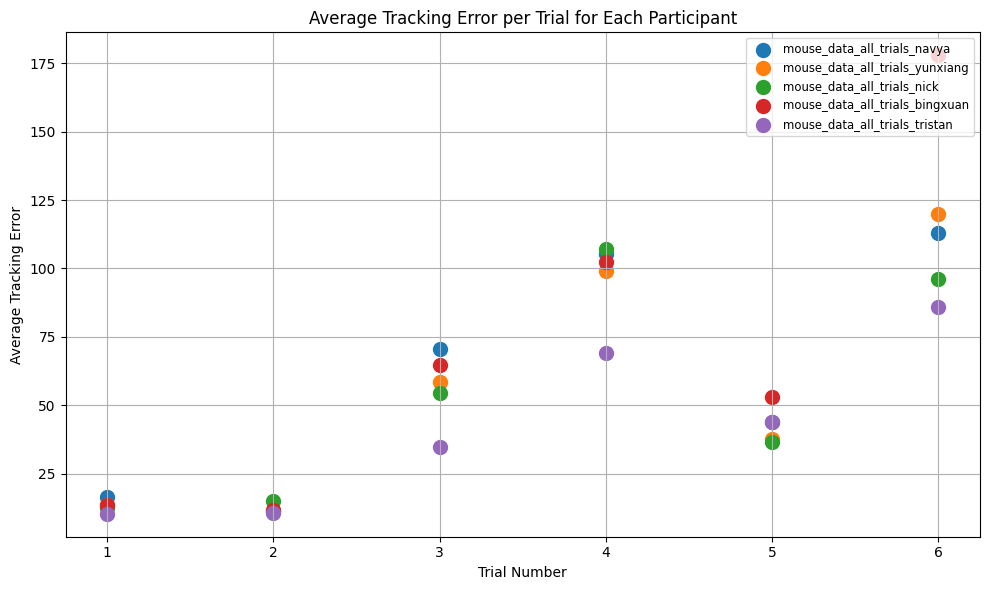

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

folder_path = 'PilotResults'

# Collect all CSV file paths
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

trial_mapping = {6: 4, 7: 5, 8: 0, 9: 1, 10: 2, 11: 3}

participant_avg_accuracy_per_trial = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)

    participant_name = os.path.basename(csv_file).replace('.csv', '')

    df['MappedTrialNumber'] = df['TrialNumber'].replace(trial_mapping)

    grouped = df.groupby('MappedTrialNumber')

    # Loop through each trial and calculate the average tracking accuracy for that trial
    for trial_number, group in grouped:
        tracking_accuracies = group['TrackingAccuracy'].values

        avg_accuracy = tracking_accuracies.mean()

        participant_avg_accuracy_per_trial.append({
            'Participant': participant_name,
            'Trial': trial_number,
            'AverageAccuracy': avg_accuracy
        })

df_avg_accuracy = pd.DataFrame(participant_avg_accuracy_per_trial)

plt.figure(figsize=(10, 6))

for participant in df_avg_accuracy['Participant'].unique():
    participant_data = df_avg_accuracy[df_avg_accuracy['Participant'] == participant]
    plt.scatter(participant_data['Trial'] + 1, participant_data['AverageAccuracy'], label=participant, s=100)

plt.xlabel('Trial Number')
plt.ylabel('Average Tracking Error')
plt.title('Average Tracking Error per Trial for Each Participant')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)

# Show the dot chart
plt.tight_layout()
plt.show()
